In [49]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input,GRU, SimpleRNN, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, History
from keras import regularizers
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import save_model


In [2]:
data = pd.read_csv('games.csv')

# Explore the dataset and clean it up as much as needed

In [3]:
data.duplicated().sum()

429

In [4]:
data = data.drop_duplicates()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19629 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              19629 non-null  object 
 1   rated           19629 non-null  bool   
 2   created_at      19629 non-null  float64
 3   last_move_at    19629 non-null  float64
 4   turns           19629 non-null  int64  
 5   victory_status  19629 non-null  object 
 6   winner          19629 non-null  object 
 7   increment_code  19629 non-null  object 
 8   white_id        19629 non-null  object 
 9   white_rating    19629 non-null  int64  
 10  black_id        19629 non-null  object 
 11  black_rating    19629 non-null  int64  
 12  moves           19629 non-null  object 
 13  opening_eco     19629 non-null  object 
 14  opening_name    19629 non-null  object 
 15  opening_ply     19629 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.4+ MB


# Only 2 columns are interesting for the purpose of this project since we deal with users that might not be regular chess players

In [6]:
data.winner.value_counts()

white    9792
black    8919
draw      918
Name: winner, dtype: int64

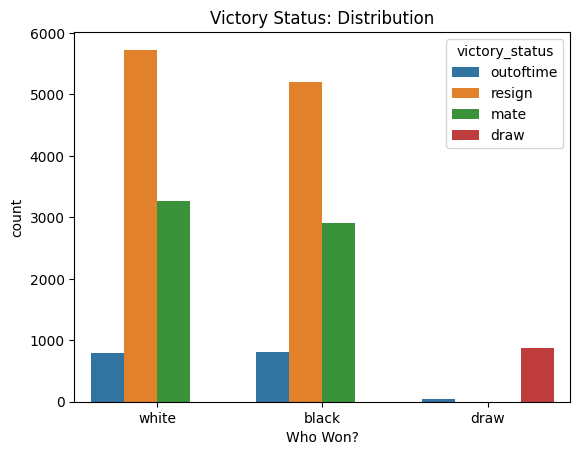

In [38]:
ax = sns.countplot( x = 'winner', hue = 'victory_status', data = data)
ax_attr = ax.set(xlabel = 'Who Won?', title = 'Victory Status: Distribution')

# Two approaches were implemented as an answer to the logical validity issue (in a binary clasification we can not say white or black is the winner because we don not consider the draw probability)
1. white, black
2. white, black, draw

In [7]:
moves = np.array(data.query("winner != 'draw'")['moves'])

In [8]:
moves_with_draw = np.array(data['moves'])

# Prepare labels for classification task

In [9]:
labels = np.array(data.query("winner != 'draw'")['winner'].apply(lambda x: 1 if x =='white' else 0))
labels

array([1, 0, 1, ..., 1, 1, 0])

In [10]:
labels_with_draw = np.array(data['winner'].apply(lambda x: 2 if x == 'draw' else 1 if x == 'white' else 0))
labels_with_draw

array([1, 0, 1, ..., 1, 1, 0])

# Create a vocabulary of all unique moves  

In [11]:
all_moves = set()
for moves_list in moves:
    for move in moves_list.split(' '):
        if move not in all_moves:
            all_moves.add(move)


vocab_length = len(all_moves)
vocab_length

4373

In [12]:
all_moves_with_draw = set()
for moves_list in moves_with_draw:
    for move in moves_list.split(' '):
        if move not in all_moves_with_draw:
            all_moves_with_draw.add(move)


vocab_length_with_draw = len(all_moves_with_draw)
vocab_length_with_draw

4447

# Get the longest sequence of moves in a game

In [13]:
max_moves = data.turns.max()
max_moves

349

In [14]:
print(vocab_length)
print(max_moves)
print(vocab_length_with_draw)
print(max_moves)

4373
349
4447
349


# Small trick to try to avoid different results on consecutive fittings

In [15]:
# trying this to stop having different results after each fitting
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Tokenize the moves (replacing the moves with numbers, the most frequent move will have the lowest number ) and padding. Dump the tokenizer to use it on our sequence to predict

In [16]:
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(moves)

sequences = tokenizer.texts_to_sequences(moves)
word_index = tokenizer.word_index

model_inputs = pad_sequences(sequences, maxlen=max_moves)

pkl.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [17]:
model_inputs.shape, labels.shape

((18711, 349), (18711,))

In [18]:
tokenizer_with_draw = Tokenizer(num_words=vocab_length_with_draw)
tokenizer_with_draw.fit_on_texts(moves_with_draw)

sequences_with_draw = tokenizer_with_draw.texts_to_sequences(moves_with_draw)
word_index_with_draw = tokenizer_with_draw.word_index

model_inputs_with_draw = pad_sequences(sequences_with_draw, maxlen=max_moves)

pkl.dump(tokenizer, open('tokenizer_with_draw.pkl', 'wb'))

In [19]:
model_inputs_with_draw.shape, labels_with_draw.shape

((19629, 349), (19629,))

# Split data for trainig and test

In [20]:
X_train,X_test,y_train,y_test = train_test_split(model_inputs, labels, test_size=0.2, random_state=42)

In [21]:
X_train_with_draw,X_test_with_draw,y_train_with_draw,y_test_with_draw = train_test_split(model_inputs_with_draw, labels_with_draw, test_size=0.2, random_state=42)

# Create RNN model: Embedding layer since we work with categorical data, GRU for sequential data, Dropout for avoiding overfitting. The rest depends because the 2 approaches defined above

In [22]:
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=256, input_length=max_moves))
model.add(GRU(units=256))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_no_draw = model.fit(X_train, y_train, epochs=3, batch_size=64, shuffle=False,validation_data=(X_test, y_test), verbose=2, callbacks=ReduceLROnPlateau())

Epoch 1/3
234/234 - 438s - loss: 0.5628 - accuracy: 0.7234 - val_loss: 0.4910 - val_accuracy: 0.7668 - lr: 0.0010 - 438s/epoch - 2s/step
Epoch 2/3
234/234 - 424s - loss: 0.4633 - accuracy: 0.7819 - val_loss: 0.4674 - val_accuracy: 0.7785 - lr: 0.0010 - 424s/epoch - 2s/step
Epoch 3/3
234/234 - 441s - loss: 0.4008 - accuracy: 0.8175 - val_loss: 0.3670 - val_accuracy: 0.8320 - lr: 0.0010 - 441s/epoch - 2s/step


In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

117/117 [==============================] - 38s 321ms/step - loss: 0.3670 - accuracy: 0.8320


In [44]:
#pkl.dump(model, open('model.pkl', 'wb'))
#save_model(model, 'model.h5')

In [26]:
model_with_draw = Sequential()
model_with_draw.add(Embedding(input_dim=vocab_length_with_draw, output_dim=256, input_length=max_moves))
#model_with_draw.add(GRU(units=256, return_sequences=True))
#model_with_draw.add(Dropout(0.5))
model_with_draw.add(GRU(units=256))
model_with_draw.add(Dropout(0.7))
model_with_draw.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

In [27]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = History()

In [28]:
model_with_draw.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_with_draw = model_with_draw.fit(X_train_with_draw, y_train_with_draw, shuffle=False, epochs=3, batch_size=64, validation_data=(X_test_with_draw, y_test_with_draw), verbose=2, callbacks=[early_stopping, history])

Epoch 1/3
246/246 - 460s - loss: 0.7496 - accuracy: 0.6811 - val_loss: 0.6529 - val_accuracy: 0.7254 - 460s/epoch - 2s/step
Epoch 2/3
246/246 - 456s - loss: 0.6268 - accuracy: 0.7422 - val_loss: 0.6072 - val_accuracy: 0.7458 - 456s/epoch - 2s/step
Epoch 3/3
246/246 - 457s - loss: 0.4851 - accuracy: 0.8139 - val_loss: 0.4239 - val_accuracy: 0.8474 - 457s/epoch - 2s/step


In [43]:
#pkl.dump(model_with_draw, open('model_with_draw.pkl', 'wb'))

In [54]:
save_model(model_with_draw, 'model_with_draw.h5')

<ipython-input-54-69739cbc1402>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_with_draw, 'model_with_draw.h5')


In [39]:
model_with_draw.evaluate(X_test_with_draw, y_test_with_draw)

123/123 [==============================] - 45s 362ms/step - loss: 0.4239 - accuracy: 0.8474


[0.4238640367984772, 0.8474274277687073]

In [41]:
y_pred = model_with_draw.predict(X_test_with_draw)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred, y_pred_classes

123/123 [==============================] - 46s 375ms/step


(array([[0.08624481, 0.8679342 , 0.04582096],
        [0.22514565, 0.63646215, 0.13839215],
        [0.5192185 , 0.38121882, 0.09956264],
        ...,
        [0.00939409, 0.98472667, 0.00587915],
        [0.04808735, 0.9435347 , 0.00837803],
        [0.8197359 , 0.08113004, 0.0991341 ]], dtype=float32),
 array([1, 1, 0, ..., 1, 1, 0]))

In [42]:
accuracy = accuracy_score(y_test_with_draw, y_pred_classes)
precision = precision_score(y_test_with_draw, y_pred_classes, average='weighted')
recall = recall_score(y_test_with_draw, y_pred_classes, average='weighted')
f1 = f1_score(y_test_with_draw, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8474
Precision: 0.8437
Recall: 0.8474
F1 Score: 0.8345


# Plot to supervize the overfitting

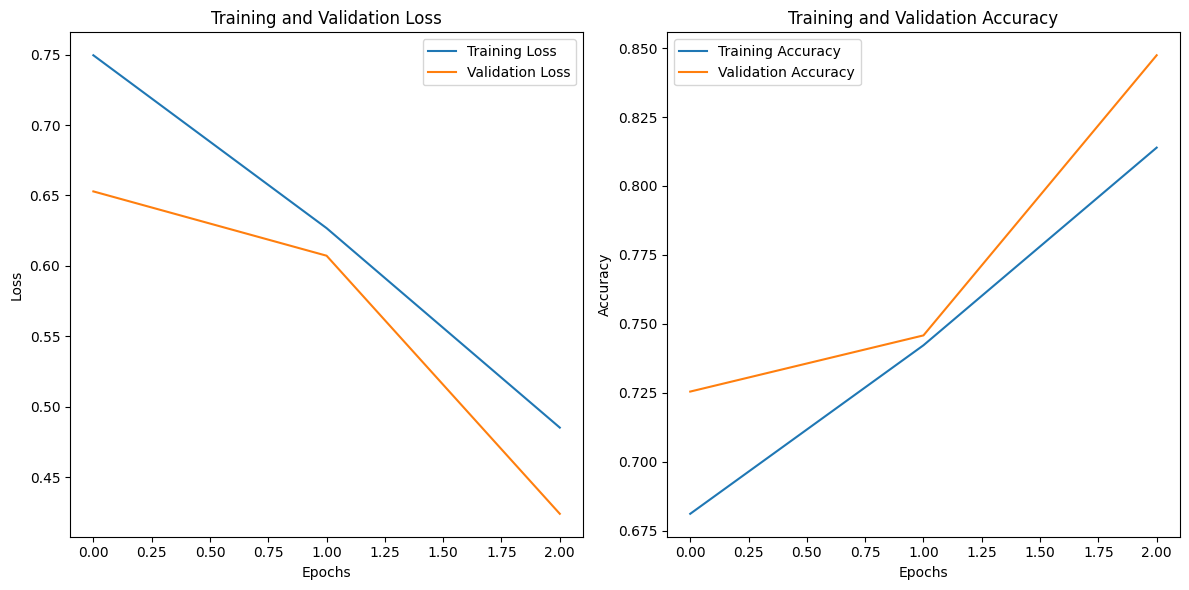

In [35]:

# Plot the learning curves
plt.figure(figsize=(12, 6))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
# a bit of underfitting